# Sequence to Sequence Modelling

**Note**: All code should be in Python3. Keras version should be 2.0.4. The directory structure on the bitbucket repo should be exactly same as the hw4.zip provided to you (with the exception of data directory. Do not upload it). To push the code to remote repo, use the same instructions as given in HW0. **Double check you remote repo for correct directory structure. We won't consider any regrade requests based on wrong directory structure penalty. Again, do not upload data to your bitbucket repo ** <br>
**The data provided to you should not be used for any other purpose than this course. You must not distribute it or upload it to any public platform.**

![title](seq2seq.png)

Name: Sicong Fang

UNI: sf2796

NLP HW4

In this assignment, we are going to solve the problem of summarization using a sequence to sequence model. In a sequence to sequence problem, we have an encoder and a decoder. We feed the sequence of word embeddings to an encoder and train decoder to learn the summaries. We will be seeing 2 types of encoder decoder architectures in this assignment

# Preparing Inputs

The first part of the assignment is to prepare data. You are given training data in train_article.txt, in which each line is the first sentence from an article, and training summary sentences in train_title.txt, which are the corresponding titles of the article. You will be training the model to predict the title of an article given the first sentence of that article, where title generation is a summarization task. Let us limit the maximum vocabulary size to 20000 and maximum length of article to 200 (These are just initial params to get you started and we recommend experimenting, to improve your scores after you are done with your first implementation)

In [96]:
MAX_LEN = 200
VOCAB_SIZE = 20000

Write a function which takes article file, summary file, maximum length of sentence and vocabulary size and does the following
* Create vocabulary: Take most frequent VOCAB_SIZE number of words from article file. Add two special symbols ZERO at start and UNK at end to finally have VOCAB_SIZE + 2 words. Use this array as idx2word. Repeat the process for summary data to create another idx2word corresponding to it. 
* Using the above idx2word for both article and summary data, create word2idx, which will map every word to its index in idx2word array. 
* Convert the words in the article and summary data to their corresponding index from word2idx. If a word is not present in the vocab, use the index of UNK. 
* After the above preprocessing, each sentence in article and summary data should be a list of indices
* Now find the max length of a sentence (which is basically number of indices in a sentence) in article data. Pad every sentence in article data to that length, so that all sentences are of same length. You may use pad_sequences function provided by keras. Do the same for title data.
* return the following outputs transformed article data, vocab size of article data, idx2word(articledata), word2idx(articledata),transformed summary data, vocab size of summary data, idx2word(summarydata), word2idx(summarydata)

In [23]:
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, TimeDistributed, Dense, RepeatVector, recurrent, Embedding
from keras.layers.recurrent import LSTM
from keras.optimizers import Adam, RMSprop
from nltk import FreqDist
import numpy as np

def load_data(article, summary, max_len, vocab_size):
## *reference: https://github.com/ChunML/seq2seq/blob/master/seq2seq_utils.py* ##
## *reference: https://chunml.github.io/ChunML.github.io/project/Sequence-To-Sequence/* ##
    X=[]
    y=[]
    with open('data/'+article, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            X.append(text_to_word_sequence(line,filters='')[:max_len])
    
    with open('data/'+summary, 'r') as f:
        for line in f.readlines():
            line = line.strip()
            y.append(text_to_word_sequence(line,filters='')[:max_len])

    # Creating the vocabulary set with the most common words
    dist = FreqDist(np.hstack(X))
    X_vocab = dist.most_common(vocab_size-1)
    dist = FreqDist(np.hstack(y))
    y_vocab = dist.most_common(vocab_size-1)

    # Creating an array of words from the vocabulary set, use this array as index-to-word dictionary
    X_ix2word = [word[0] for word in X_vocab]
    # Adding the word "ZERO" to the beginning of the array
    X_ix2word.insert(0, 'ZERO')
    # Adding the word 'UNK' to the end of the array 
    X_ix2word.append('UNK')
    # Creating the word-to-index dictionary from the array created above
    X_word2ix = {word:ix for ix, word in enumerate(X_ix2word)}
    # Converting each word to its index value
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word2ix:
                X[i][j] = X_word2ix[word]
            else:
                X[i][j] = X_word2ix['UNK']

    y_ix2word = [word[0] for word in y_vocab]
    y_ix2word.insert(0, 'ZERO')
    y_ix2word.append('UNK')
    y_word2ix = {word:ix for ix, word in enumerate(y_ix2word)}
    for i, sentence in enumerate(y):
        for j, word in enumerate(sentence):
            if word in y_word2ix:
                y[i][j] = y_word2ix[word]
            else:
                y[i][j] = y_word2ix['UNK']
    return (X, len(X_vocab)+2, X_ix2word, X_word2ix, y, len(y_vocab)+2, y_ix2word,y_word2ix)

Now use the above function to load the training data from article and summary (i.e. title) files. Do note that, based on your model architecture, you may need to further one-hot vectorize your input to the model

In [97]:
# TO-DO
X, length_X, X_ix2word, X_word2ix, y, length_y, y_ix2word,y_word2ix = load_data('train_article.txt','train_title.txt',MAX_LEN,VOCAB_SIZE)


# Unidirectional LSTM Encoder Decoder 

Define the parameters for your LSTM encoder decoder model. 

In [98]:
BATCH_SIZE = 128
NUM_LAYERS = 2
HIDDEN_DIM = 512
EPOCHS = 24

Create a Unidirectional encoder decoder LSTM model in create_model function. The model should have a LSTM Unidirectional layer as encoder and a LSTM decoder.
Use categorical_cross_entropy loss and experiment with different optimizers to improve your score.

In [99]:
def create_UniLSTM(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder
    # Creating encoder network
    model = Sequential()
    model.add(Embedding(X_vocab_len, 1000, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size))
    model.add(RepeatVector(y_max_len))

    # Creating decoder network
    for _ in range(num_layers):
        model.add(LSTM(hidden_size, return_sequences=True))
    model.add(TimeDistributed(Dense(y_vocab_len)))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy',
            optimizer='rmsprop',
            metrics=['accuracy'])
    return model


# Train the Model

Now that we have everything in place, we can run our model. We recommend training the model in batches instead of training on all 50,000 article-title pairs at once, if you encounter memory contraints

In [27]:
def process_data(word_sentences, max_len, word_to_ix):
    # Vectorizing each element in each sequence
    sequences = np.zeros((len(word_sentences), max_len, len(word_to_ix)))
    for i, sentence in enumerate(word_sentences):
        for j, word in enumerate(sentence):
            sequences[i, j, word] = 1.
    return sequences

In [9]:
# TO-DO
# Finding the length of the longest sequence
import os
X_max_len = max([len(sentence) for sentence in X])
y_max_len = max([len(sentence) for sentence in y])

# Padding zeros to make all sequences have a same length with the longest one
print('[INFO] Zero padding...')
X = pad_sequences(X, maxlen=X_max_len, dtype='int32')
y = pad_sequences(y, maxlen=y_max_len, dtype='int32')

# Creating the network model
print('[INFO] Compiling model...')
model = create_UniLSTM(length_X, X_max_len, length_y, y_max_len, HIDDEN_DIM, NUM_LAYERS)
k_start = 1
i_end = 0
for k in range(k_start, EPOCHS+1):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]
    for i in range(0, len(X), 1000):
        if i + 1000 >= len(X):
            i_end = len(X)
        else:
            i_end = i + 1000
        y_sequences = process_data(y[i:i_end], y_max_len, y_word2ix)

        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
        model.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, epochs=1, verbose=2)
        model.save_weights('saved_weights_no_attention_epoch_{}.hdf5'.format(k))

[INFO] Zero padding...
[INFO] Compiling model...
[INFO] Training model: epoch 1th 0/50000 samples
Epoch 1/1
12s - loss: 5.3647 - acc: 0.6712
[INFO] Training model: epoch 1th 1000/50000 samples
Epoch 1/1
10s - loss: 2.4629 - acc: 0.7684
[INFO] Training model: epoch 1th 2000/50000 samples
Epoch 1/1
9s - loss: 2.4419 - acc: 0.7670
[INFO] Training model: epoch 1th 3000/50000 samples
Epoch 1/1
10s - loss: 2.4381 - acc: 0.7660
[INFO] Training model: epoch 1th 4000/50000 samples
Epoch 1/1
9s - loss: 2.4468 - acc: 0.7641
[INFO] Training model: epoch 1th 5000/50000 samples
Epoch 1/1
10s - loss: 2.4385 - acc: 0.7658
[INFO] Training model: epoch 1th 6000/50000 samples
Epoch 1/1
9s - loss: 2.4354 - acc: 0.7673
[INFO] Training model: epoch 1th 7000/50000 samples
Epoch 1/1
10s - loss: 2.3864 - acc: 0.7702
[INFO] Training model: epoch 1th 8000/50000 samples
Epoch 1/1
10s - loss: 2.4537 - acc: 0.7664
[INFO] Training model: epoch 1th 9000/50000 samples
Epoch 1/1
9s - loss: 2.4206 - acc: 0.7698
[INFO] T

10s - loss: 2.0339 - acc: 0.7697
[INFO] Training model: epoch 2th 36000/50000 samples
Epoch 1/1
10s - loss: 2.0136 - acc: 0.7720
[INFO] Training model: epoch 2th 37000/50000 samples
Epoch 1/1
10s - loss: 2.0558 - acc: 0.7686
[INFO] Training model: epoch 2th 38000/50000 samples
Epoch 1/1
9s - loss: 2.0314 - acc: 0.7691
[INFO] Training model: epoch 2th 39000/50000 samples
Epoch 1/1
9s - loss: 2.0357 - acc: 0.7669
[INFO] Training model: epoch 2th 40000/50000 samples
Epoch 1/1
10s - loss: 2.0457 - acc: 0.7679
[INFO] Training model: epoch 2th 41000/50000 samples
Epoch 1/1
10s - loss: 2.0391 - acc: 0.7667
[INFO] Training model: epoch 2th 42000/50000 samples
Epoch 1/1
9s - loss: 2.0182 - acc: 0.7700
[INFO] Training model: epoch 2th 43000/50000 samples
Epoch 1/1
10s - loss: 1.9933 - acc: 0.7696
[INFO] Training model: epoch 2th 44000/50000 samples
Epoch 1/1
9s - loss: 1.9540 - acc: 0.7744
[INFO] Training model: epoch 2th 45000/50000 samples
Epoch 1/1
10s - loss: 1.9850 - acc: 0.7725
[INFO] Trai

[INFO] Training model: epoch 4th 22000/50000 samples
Epoch 1/1
10s - loss: 1.8877 - acc: 0.7708
[INFO] Training model: epoch 4th 23000/50000 samples
Epoch 1/1
9s - loss: 1.8494 - acc: 0.7771
[INFO] Training model: epoch 4th 24000/50000 samples
Epoch 1/1
10s - loss: 1.8360 - acc: 0.7767
[INFO] Training model: epoch 4th 25000/50000 samples
Epoch 1/1
9s - loss: 1.8868 - acc: 0.7706
[INFO] Training model: epoch 4th 26000/50000 samples
Epoch 1/1
10s - loss: 1.9088 - acc: 0.7697
[INFO] Training model: epoch 4th 27000/50000 samples
Epoch 1/1
10s - loss: 1.9192 - acc: 0.7686
[INFO] Training model: epoch 4th 28000/50000 samples
Epoch 1/1
10s - loss: 1.8356 - acc: 0.7780
[INFO] Training model: epoch 4th 29000/50000 samples
Epoch 1/1
9s - loss: 1.8956 - acc: 0.7712
[INFO] Training model: epoch 4th 30000/50000 samples
Epoch 1/1
10s - loss: 1.8874 - acc: 0.7706
[INFO] Training model: epoch 4th 31000/50000 samples
Epoch 1/1
9s - loss: 1.8726 - acc: 0.7725
[INFO] Training model: epoch 4th 32000/50000

[INFO] Training model: epoch 6th 8000/50000 samples
Epoch 1/1
9s - loss: 1.7946 - acc: 0.7769
[INFO] Training model: epoch 6th 9000/50000 samples
Epoch 1/1
10s - loss: 1.7863 - acc: 0.7799
[INFO] Training model: epoch 6th 10000/50000 samples
Epoch 1/1
9s - loss: 1.8669 - acc: 0.7715
[INFO] Training model: epoch 6th 11000/50000 samples
Epoch 1/1
10s - loss: 1.7861 - acc: 0.7778
[INFO] Training model: epoch 6th 12000/50000 samples
Epoch 1/1
9s - loss: 1.7906 - acc: 0.7788
[INFO] Training model: epoch 6th 13000/50000 samples
Epoch 1/1
10s - loss: 1.8138 - acc: 0.7768
[INFO] Training model: epoch 6th 14000/50000 samples
Epoch 1/1
9s - loss: 1.8272 - acc: 0.7753
[INFO] Training model: epoch 6th 15000/50000 samples
Epoch 1/1
9s - loss: 1.8150 - acc: 0.7741
[INFO] Training model: epoch 6th 16000/50000 samples
Epoch 1/1
9s - loss: 1.7694 - acc: 0.7806
[INFO] Training model: epoch 6th 17000/50000 samples
Epoch 1/1
9s - loss: 1.8232 - acc: 0.7737
[INFO] Training model: epoch 6th 18000/50000 samp

[INFO] Training model: epoch 7th 44000/50000 samples
Epoch 1/1
10s - loss: 1.7742 - acc: 0.7773
[INFO] Training model: epoch 7th 45000/50000 samples
Epoch 1/1
10s - loss: 1.7955 - acc: 0.7764
[INFO] Training model: epoch 7th 46000/50000 samples
Epoch 1/1
10s - loss: 1.7788 - acc: 0.7761
[INFO] Training model: epoch 7th 47000/50000 samples
Epoch 1/1
10s - loss: 1.7369 - acc: 0.7807
[INFO] Training model: epoch 7th 48000/50000 samples
Epoch 1/1
10s - loss: 1.7834 - acc: 0.7774
[INFO] Training model: epoch 7th 49000/50000 samples
Epoch 1/1
10s - loss: 1.7714 - acc: 0.7791
[INFO] Training model: epoch 8th 0/50000 samples
Epoch 1/1
10s - loss: 1.7127 - acc: 0.7783
[INFO] Training model: epoch 8th 1000/50000 samples
Epoch 1/1
10s - loss: 1.6899 - acc: 0.7802
[INFO] Training model: epoch 8th 2000/50000 samples
Epoch 1/1
9s - loss: 1.7620 - acc: 0.7721
[INFO] Training model: epoch 8th 3000/50000 samples
Epoch 1/1
9s - loss: 1.7233 - acc: 0.7806
[INFO] Training model: epoch 8th 4000/50000 sampl

[INFO] Training model: epoch 9th 30000/50000 samples
Epoch 1/1
10s - loss: 1.6927 - acc: 0.7814
[INFO] Training model: epoch 9th 31000/50000 samples
Epoch 1/1
10s - loss: 1.7102 - acc: 0.7793
[INFO] Training model: epoch 9th 32000/50000 samples
Epoch 1/1
10s - loss: 1.6934 - acc: 0.7810
[INFO] Training model: epoch 9th 33000/50000 samples
Epoch 1/1
10s - loss: 1.7045 - acc: 0.7816
[INFO] Training model: epoch 9th 34000/50000 samples
Epoch 1/1
10s - loss: 1.7012 - acc: 0.7835
[INFO] Training model: epoch 9th 35000/50000 samples
Epoch 1/1
10s - loss: 1.7600 - acc: 0.7767
[INFO] Training model: epoch 9th 36000/50000 samples
Epoch 1/1
10s - loss: 1.6882 - acc: 0.7824
[INFO] Training model: epoch 9th 37000/50000 samples
Epoch 1/1
10s - loss: 1.7177 - acc: 0.7807
[INFO] Training model: epoch 9th 38000/50000 samples
Epoch 1/1
10s - loss: 1.7067 - acc: 0.7794
[INFO] Training model: epoch 9th 39000/50000 samples
Epoch 1/1
10s - loss: 1.7241 - acc: 0.7797
[INFO] Training model: epoch 9th 40000/5

9s - loss: 1.6068 - acc: 0.7857
[INFO] Training model: epoch 11th 16000/50000 samples
Epoch 1/1
10s - loss: 1.6199 - acc: 0.7845
[INFO] Training model: epoch 11th 17000/50000 samples
Epoch 1/1
9s - loss: 1.6036 - acc: 0.7848
[INFO] Training model: epoch 11th 18000/50000 samples
Epoch 1/1
9s - loss: 1.6152 - acc: 0.7871
[INFO] Training model: epoch 11th 19000/50000 samples
Epoch 1/1
9s - loss: 1.5814 - acc: 0.7889
[INFO] Training model: epoch 11th 20000/50000 samples
Epoch 1/1
10s - loss: 1.6251 - acc: 0.7830
[INFO] Training model: epoch 11th 21000/50000 samples
Epoch 1/1
10s - loss: 1.6510 - acc: 0.7804
[INFO] Training model: epoch 11th 22000/50000 samples
Epoch 1/1
9s - loss: 1.6453 - acc: 0.7817
[INFO] Training model: epoch 11th 23000/50000 samples
Epoch 1/1
10s - loss: 1.6333 - acc: 0.7863
[INFO] Training model: epoch 11th 24000/50000 samples
Epoch 1/1
9s - loss: 1.6214 - acc: 0.7845
[INFO] Training model: epoch 11th 25000/50000 samples
Epoch 1/1
10s - loss: 1.6581 - acc: 0.7826
[IN

10s - loss: 1.5782 - acc: 0.7836
[INFO] Training model: epoch 13th 1000/50000 samples
Epoch 1/1
10s - loss: 1.5383 - acc: 0.7866
[INFO] Training model: epoch 13th 2000/50000 samples
Epoch 1/1
10s - loss: 1.5353 - acc: 0.7853
[INFO] Training model: epoch 13th 3000/50000 samples
Epoch 1/1
10s - loss: 1.5371 - acc: 0.7863
[INFO] Training model: epoch 13th 4000/50000 samples
Epoch 1/1
10s - loss: 1.5482 - acc: 0.7858
[INFO] Training model: epoch 13th 5000/50000 samples
Epoch 1/1
10s - loss: 1.5481 - acc: 0.7843
[INFO] Training model: epoch 13th 6000/50000 samples
Epoch 1/1
9s - loss: 1.5528 - acc: 0.7863
[INFO] Training model: epoch 13th 7000/50000 samples
Epoch 1/1
10s - loss: 1.5542 - acc: 0.7850
[INFO] Training model: epoch 13th 8000/50000 samples
Epoch 1/1
10s - loss: 1.5136 - acc: 0.7898
[INFO] Training model: epoch 13th 9000/50000 samples
Epoch 1/1
10s - loss: 1.5749 - acc: 0.7822
[INFO] Training model: epoch 13th 10000/50000 samples
Epoch 1/1
9s - loss: 1.5402 - acc: 0.7862
[INFO] T

10s - loss: 1.5622 - acc: 0.7861
[INFO] Training model: epoch 14th 36000/50000 samples
Epoch 1/1
10s - loss: 1.5756 - acc: 0.7820
[INFO] Training model: epoch 14th 37000/50000 samples
Epoch 1/1
10s - loss: 1.5456 - acc: 0.7864
[INFO] Training model: epoch 14th 38000/50000 samples
Epoch 1/1
10s - loss: 1.5339 - acc: 0.7878
[INFO] Training model: epoch 14th 39000/50000 samples
Epoch 1/1
10s - loss: 1.5465 - acc: 0.7862
[INFO] Training model: epoch 14th 40000/50000 samples
Epoch 1/1
10s - loss: 1.5414 - acc: 0.7850
[INFO] Training model: epoch 14th 41000/50000 samples
Epoch 1/1
10s - loss: 1.5497 - acc: 0.7865
[INFO] Training model: epoch 14th 42000/50000 samples
Epoch 1/1
10s - loss: 1.5430 - acc: 0.7856
[INFO] Training model: epoch 14th 43000/50000 samples
Epoch 1/1
10s - loss: 1.5207 - acc: 0.7915
[INFO] Training model: epoch 14th 44000/50000 samples
Epoch 1/1
10s - loss: 1.5403 - acc: 0.7892
[INFO] Training model: epoch 14th 45000/50000 samples
Epoch 1/1
10s - loss: 1.5190 - acc: 0.79

9s - loss: 1.4142 - acc: 0.7951
[INFO] Training model: epoch 16th 21000/50000 samples
Epoch 1/1
10s - loss: 1.4499 - acc: 0.7910
[INFO] Training model: epoch 16th 22000/50000 samples
Epoch 1/1
10s - loss: 1.4647 - acc: 0.7888
[INFO] Training model: epoch 16th 23000/50000 samples
Epoch 1/1
10s - loss: 1.4453 - acc: 0.7922
[INFO] Training model: epoch 16th 24000/50000 samples
Epoch 1/1
10s - loss: 1.4227 - acc: 0.7957
[INFO] Training model: epoch 16th 25000/50000 samples
Epoch 1/1
10s - loss: 1.4565 - acc: 0.7920
[INFO] Training model: epoch 16th 26000/50000 samples
Epoch 1/1
9s - loss: 1.4669 - acc: 0.7905
[INFO] Training model: epoch 16th 27000/50000 samples
Epoch 1/1
10s - loss: 1.4354 - acc: 0.7940
[INFO] Training model: epoch 16th 28000/50000 samples
Epoch 1/1
9s - loss: 1.4831 - acc: 0.7874
[INFO] Training model: epoch 16th 29000/50000 samples
Epoch 1/1
9s - loss: 1.4967 - acc: 0.7868
[INFO] Training model: epoch 16th 30000/50000 samples
Epoch 1/1
9s - loss: 1.4172 - acc: 0.7964
[I

10s - loss: 1.3668 - acc: 0.7926
[INFO] Training model: epoch 18th 6000/50000 samples
Epoch 1/1
10s - loss: 1.3376 - acc: 0.7964
[INFO] Training model: epoch 18th 7000/50000 samples
Epoch 1/1
10s - loss: 1.3632 - acc: 0.7932
[INFO] Training model: epoch 18th 8000/50000 samples
Epoch 1/1
10s - loss: 1.3653 - acc: 0.7935
[INFO] Training model: epoch 18th 9000/50000 samples
Epoch 1/1
10s - loss: 1.3431 - acc: 0.7972
[INFO] Training model: epoch 18th 10000/50000 samples
Epoch 1/1
10s - loss: 1.3543 - acc: 0.7949
[INFO] Training model: epoch 18th 11000/50000 samples
Epoch 1/1
10s - loss: 1.3960 - acc: 0.7894
[INFO] Training model: epoch 18th 12000/50000 samples
Epoch 1/1
10s - loss: 1.3658 - acc: 0.7954
[INFO] Training model: epoch 18th 13000/50000 samples
Epoch 1/1
10s - loss: 1.3562 - acc: 0.7947
[INFO] Training model: epoch 18th 14000/50000 samples
Epoch 1/1
10s - loss: 1.4363 - acc: 0.7863
[INFO] Training model: epoch 18th 15000/50000 samples
Epoch 1/1
10s - loss: 1.3600 - acc: 0.7969
[

10s - loss: 1.3605 - acc: 0.7963
[INFO] Training model: epoch 19th 41000/50000 samples
Epoch 1/1
10s - loss: 1.3985 - acc: 0.7955
[INFO] Training model: epoch 19th 42000/50000 samples
Epoch 1/1
9s - loss: 1.4078 - acc: 0.7924
[INFO] Training model: epoch 19th 43000/50000 samples
Epoch 1/1
10s - loss: 1.3906 - acc: 0.7929
[INFO] Training model: epoch 19th 44000/50000 samples
Epoch 1/1
10s - loss: 1.3904 - acc: 0.7926
[INFO] Training model: epoch 19th 45000/50000 samples
Epoch 1/1
10s - loss: 1.3855 - acc: 0.7936
[INFO] Training model: epoch 19th 46000/50000 samples
Epoch 1/1
9s - loss: 1.3859 - acc: 0.7910
[INFO] Training model: epoch 19th 47000/50000 samples
Epoch 1/1
10s - loss: 1.3889 - acc: 0.7951
[INFO] Training model: epoch 19th 48000/50000 samples
Epoch 1/1
10s - loss: 1.3908 - acc: 0.7935
[INFO] Training model: epoch 19th 49000/50000 samples
Epoch 1/1
9s - loss: 1.3615 - acc: 0.7980
[INFO] Training model: epoch 20th 0/50000 samples
Epoch 1/1
9s - loss: 1.3069 - acc: 0.7982
[INFO

10s - loss: 1.3196 - acc: 0.7955
[INFO] Training model: epoch 21th 26000/50000 samples
Epoch 1/1
10s - loss: 1.3113 - acc: 0.7985
[INFO] Training model: epoch 21th 27000/50000 samples
Epoch 1/1
9s - loss: 1.3097 - acc: 0.7968
[INFO] Training model: epoch 21th 28000/50000 samples
Epoch 1/1
10s - loss: 1.3209 - acc: 0.7963
[INFO] Training model: epoch 21th 29000/50000 samples
Epoch 1/1
9s - loss: 1.2974 - acc: 0.7988
[INFO] Training model: epoch 21th 30000/50000 samples
Epoch 1/1
10s - loss: 1.3163 - acc: 0.7941
[INFO] Training model: epoch 21th 31000/50000 samples
Epoch 1/1
10s - loss: 1.3169 - acc: 0.7978
[INFO] Training model: epoch 21th 32000/50000 samples
Epoch 1/1
10s - loss: 1.3319 - acc: 0.7950
[INFO] Training model: epoch 21th 33000/50000 samples
Epoch 1/1
10s - loss: 1.3330 - acc: 0.7964
[INFO] Training model: epoch 21th 34000/50000 samples
Epoch 1/1
10s - loss: 1.3092 - acc: 0.7992
[INFO] Training model: epoch 21th 35000/50000 samples
Epoch 1/1
10s - loss: 1.3464 - acc: 0.7967

10s - loss: 1.2742 - acc: 0.7994
[INFO] Training model: epoch 23th 11000/50000 samples
Epoch 1/1
10s - loss: 1.2463 - acc: 0.8015
[INFO] Training model: epoch 23th 12000/50000 samples
Epoch 1/1
10s - loss: 1.2233 - acc: 0.8040
[INFO] Training model: epoch 23th 13000/50000 samples
Epoch 1/1
10s - loss: 1.2267 - acc: 0.8027
[INFO] Training model: epoch 23th 14000/50000 samples
Epoch 1/1
10s - loss: 1.2640 - acc: 0.8005
[INFO] Training model: epoch 23th 15000/50000 samples
Epoch 1/1
10s - loss: 1.2193 - acc: 0.8049
[INFO] Training model: epoch 23th 16000/50000 samples
Epoch 1/1
10s - loss: 1.2705 - acc: 0.7978
[INFO] Training model: epoch 23th 17000/50000 samples
Epoch 1/1
10s - loss: 1.2356 - acc: 0.8034
[INFO] Training model: epoch 23th 18000/50000 samples
Epoch 1/1
10s - loss: 1.2327 - acc: 0.8013
[INFO] Training model: epoch 23th 19000/50000 samples
Epoch 1/1
10s - loss: 1.2301 - acc: 0.8055
[INFO] Training model: epoch 23th 20000/50000 samples
Epoch 1/1
10s - loss: 1.2040 - acc: 0.80

10s - loss: 1.2359 - acc: 0.8042
[INFO] Training model: epoch 24th 46000/50000 samples
Epoch 1/1
10s - loss: 1.2730 - acc: 0.8013
[INFO] Training model: epoch 24th 47000/50000 samples
Epoch 1/1
10s - loss: 1.2584 - acc: 0.8023
[INFO] Training model: epoch 24th 48000/50000 samples
Epoch 1/1
10s - loss: 1.2476 - acc: 0.8023
[INFO] Training model: epoch 24th 49000/50000 samples
Epoch 1/1
10s - loss: 1.2315 - acc: 0.8070


In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 24, 1000)          20001000  
_________________________________________________________________
lstm_7 (LSTM)                (None, 512)               3098624   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 32, 512)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32, 512)           2099200   
_________________________________________________________________
lstm_9 (LSTM)                (None, 32, 512)           2099200   
_________________________________________________________________
time_distributed_3 (TimeDist (None, 32, 20001)         10260513  
_________________________________________________________________
activation_3 (Activation)    (None, 32, 20001)         0         
Total para

In [100]:
# Reload saved model weights
import os
X_max_len = max([len(sentence) for sentence in X])
y_max_len = max([len(sentence) for sentence in y])

# Padding zeros to make all sequences have a same length with the longest one
print('[INFO] Zero padding...')
X = pad_sequences(X, maxlen=X_max_len, dtype='int32')
y = pad_sequences(y, maxlen=y_max_len, dtype='int32')

model = create_UniLSTM(length_X, X_max_len, length_y, y_max_len, HIDDEN_DIM, NUM_LAYERS)

[INFO] Zero padding...


In [101]:

model.load_weights('saved_weights_no_attention_epoch_20.hdf5')


In [102]:
def load_test_data(source, X_word_to_ix, max_len):
    f = open(source, 'r')
    X_data = f.read()
    f.close()

    X = [text_to_word_sequence(x)[::-1] for x in X_data.split('\n') if len(x) > 0 and len(x) <= max_len]
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word_to_ix:
                X[i][j] = X_word_to_ix[word]
            else:
                X[i][j] = X_word_to_ix['UNK']
    return X
X_test = load_test_data('data/test_article.txt', X_word2ix, MAX_LEN)
X_test = pad_sequences(X_test, maxlen=X_max_len, dtype='int32')
#model.load_weights(saved_weights)

predictions = np.argmax(model.predict(X_test), axis=2)
sequences = []
for prediction in predictions:
    sequence = ' '.join([y_ix2word[index] for index in prediction if index > 0])
    print(sequence)
    sequences.append(sequence)


market stock market prices prices
market market market market prices
UNK in in stocks
UNK UNK UNK of of of the <unk>
a to for for time
to to to with sent
stock stock in in in in market
to to to to to to in make
of of of of of of of too
to to to to to UNK
UNK of of of of of of of UNK
the for for the agent to to for
to to to to to to UNK
UNK UNK UNK for for UNK
to for with the UNK
to to to to to to for for UNK
to to for for olympic olympics
to to to to in UNK
to to to to to to in find
UNK to to to to to for stock brazil
UNK UNK the UNK
's to to with in jackson
to to to to to for to market
UNK to to for for in UNK
UNK UNK UNK UNK UNK
's to to for for the UNK
to to to to for stock market
's to to to to the stock
the the the for of the UNK
trading trading to trading in stock stocks
's to to to for for in ####
to to to to on in trading
's to for in in UNK
UNK to to for UNK
to to to to for for market
weather to to to to at the judge
's to for for message
's 's to to a a the UNK
UNK UNK UNK UN

end fall in in in in trading
UNK to for <unk>
to to to to to for in china
the for for <unk>
the the the the for for the security
france france in in in in france
global 's market stock in in west
to to to to to for the UNK
of of of of in in the UNK
stocks stocks stocks close center
UNK UNK to for for for UNK
stocks stocks stocks in early trading
to to to to for olympic team
to to to for this year
to to to to UNK australia
opens hong in hong kong
to to to ### eastern
construction to to to to construction
UNK to of for for of australia
opens hong in hong kong
closes hong in hong kong
world to to to to for for the UNK
to for the news
's to to to for for broadway market
in in in in in in in UNK
a to for of UNK
stock stock stocks in for this day
jordan for for for of away
's to to to to for in bosnia
's 's to to to for the UNK
to to for for for olympic olympics
to to for in australia
to to in in UNK
stocks stocks stocks on on in in oil stocks
UNK UNK a the <unk>
zealand in closes closed
qui

the the the the for for the season
to to to to to to stewart
UNK UNK UNK UNK a a the <unk>
's to to to to for for in taiwan
to to to to to to to UNK
to to to to in cup cup
a in UNK
street street street the the the street
UNK to to for in olympics
's 's to to to for the UNK
to to to to for in UNK
's 's for for the spurs
to for for for become
to to to for the news
to to to to to to to UNK
to to to to to in against #-#
UNK UNK UNK of of UNK
the for for the found
the the the the the in the news
UNK to to to to of sunday
UNK to to to coach
UNK to to to for for UNK
to to to to to to to plans
UNK to to for in UNK
to to to to skorean
to to to team
UNK to to in 's UNK
to to to to for broadway agent
the the the the the the the <unk>
UNK to to to to for to UNK
's to to for the ever
UNK to for the UNK
UNK UNK UNK
to to for the UNK
to to to to to in in brazil
the the the the a a the UNK
UNK in of of with with with of UNK
UNK of to to to to to of of UNK
to to to to to the march
to to to with with th

's to to to to for for for UNK
UNK UNK 's 's to to for team
is is a the limits
to to to to in become
to to to for for for UNK
the the the the the a the UNK
of at at of at at british manager
to to to to for for the senator
of of of too of of too
UNK of of of at drive dies
the the to to in the news
UNK UNK to to to of UNK
's to to survival
to to to to to to UNK
anniversary to to of of of of wing
the but but but a the rare
to to to to market
to to to the UNK
north UNK UNK for for for UNK
UNK to in in next
to to in in ###
of of of of in reports bay york
UNK in to to to to to of UNK
paris to to to paris bonds
georgia georgia georgia to for for market
's 's to 's 's without
looking to in draw
to to in in market
to to in to to to in in become
to to to to for for in UNK
's to in in in in in UNK
to to to to to in britain
to to to to in in cup cup
is to for for spurs
to to to to to to to to the UNK
UNK the the a a the european
UNK UNK of at australian UNK
is is for the UNK
in in in in in in trad

In [17]:
# Process title test data, replace words not in the y_word2ix with 'UNK'
with open('data/test_title.txt', 'r') as f:
    y_test=f.readlines()
y_test_new=[]
for sentence in y_test:
    sen_new=[]
    for word in text_to_word_sequence(sentence,filters=""):
        if word in list(y_word2ix.keys()):
            word = word
        else:
            word = 'UNK'
        sen_new.append(word)
    sen_str = " ".join(i for i in sen_new)
    y_test_new.append(sen_str)

In [19]:
y_test_new

['london share prices up at UNK',
 'london share prices down at UNK',
 'kewell ready for jeers when liverpool hosts UNK',
 'most rwc tries UNK UNK',
 'u.s. open referee masters art of UNK',
 'san jose defenseman gary UNK to UNK',
 'stocks finish down in mexico chile ; rise sharply in UNK',
 'the green book _ ##,### songs #,### UNK _ popular with industry pros music UNK',
 'caracas police become latest target of political violence in UNK',
 "racing still schumacher 's UNK",
 'lawn bowls and UNK bowling distant UNK at commonwealth UNK',
 "bailey 's career threatened after basketball UNK",
 "leader of kohl 's UNK ally party steps UNK",
 '<unk> island seeks money from olympic UNK',
 'holyfield receives medical UNK to fight UNK',
 'UNK UNK knows joke is on UNK',
 'UNK celebrates ## UNK',
 'royals release paul UNK',
 'homeless have address for UNK',
 '<unk> named new austria UNK',
 'robbery suspect uses UNK card leading to UNK',
 'beckham injures his right ankle in UNK',
 'pixar s up to open

# Evaluation using Rouge score 

Now that you have trained the model, load the test data i.e. test_article.txt and corresponding reference titles test_title.txt. Process test_article.txt in the same way as you did your train_article.txt. Then use your model to predict the titles.
When you have your model predicted titles, and the reference titles (test_title.txt) calculate the Rouge score corresponding to your predictions. <br>
You should install rouge by executing "pip3 install rouge". Refer https://pypi.python.org/pypi/rouge/0.2.1 for documentation on how to use the package.

In [20]:
# TO-DO
from rouge import Rouge 
rouge = Rouge()
scores = rouge.get_scores(y_test_new, sequences,avg=True)
scores

{'rouge-1': {'f': 0.16420854873488186,
  'p': 0.12653144153318302,
  'r': 0.26645646258503397},
 'rouge-2': {'f': 0.0065334623011982541,
  'p': 0.0056562447473161755,
  'r': 0.0094775510204081637},
 'rouge-l': {'f': 0.11922796095108953,
  'p': 0.12330211028915573,
  'r': 0.14271594318380032}}

# Tensorboard Visualization 

We recommended training the data in batches because of our tensor constraints. This also presents us with a challenge of visualizing loss function and accuracy change with each epoch. Keras has an inbuilt function called fit_generator which takes in a generator function and gives the required batch for training. Use this Function to load data in batches of 100 for 200 steps_per_epoch. Run the training for 10 epochs. Use Keras callbacks to send data to tensorboad (you can look this up online). 

Once your training is done. Go to command line and run tensorboard. By default Tensorboard opens on 6006 port. Do remember to allow traffic on the same for gcloud (like you did for previous assignment). You can see various metrics depending on what you want to track like loss, accuracy, validation loss and validation accuracy over epochs. Attach the plots of loss and accuracy from the tensorboard display in the notebook

In [35]:
# TO-DO

EPOCHS = 10
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)
def tb_generator(X, y, batch_size):
    while True:
        index = np.random.choice(500,1)
        ind = index[0]*100
        end = ind+100
        X_out = X[ind:end]
        y_seq = process_data(y[ind:end], y_max_len, y_word2ix)
        yield X_out, y_seq
        
model.fit_generator(tb_generator(X, y, 100), epochs=10, steps_per_epoch=200, callbacks=[tensorboard])


Epoch 1/10
200/200 [==============================] - 165s - loss: 1.4633 - acc: 0.7965   
Epoch 2/10
200/200 [==============================] - 164s - loss: 1.4214 - acc: 0.7981   
Epoch 3/10
200/200 [==============================] - 163s - loss: 1.4411 - acc: 0.7954   
Epoch 4/10
200/200 [==============================] - 163s - loss: 1.4130 - acc: 0.7982   
Epoch 5/10
200/200 [==============================] - 162s - loss: 1.4298 - acc: 0.7954   
Epoch 6/10
200/200 [==============================] - 164s - loss: 1.3860 - acc: 0.8005   
Epoch 7/10
200/200 [==============================] - 162s - loss: 1.3930 - acc: 0.7982   
Epoch 8/10
200/200 [==============================] - 163s - loss: 1.3718 - acc: 0.8003   
Epoch 9/10
200/200 [==============================] - 164s - loss: 1.3169 - acc: 0.8043   
Epoch 10/10
200/200 [==============================] - 164s - loss: 1.2880 - acc: 0.8079   


Output:

I have the "events.out.tfevents.1513114916.instance-1" saved in logs but and tried many times to open tensorboard. It always shows "No dashboards are active for the current data set." Therefore, I was not able to upload the plots hear. 

# Unidirectional LSTM Encoder Decoder With Attention 

Define the parameters for your LSTM encoder decoder model with attention

In [5]:
BATCH_SIZE = 128
NUM_LAYERS = 1
HIDDEN_DIM = 128
EPOCHS = 24

You would've observed that the summaries are not yet perfect. This is because in encoder decoder architecture, only the final state of encoder is used to calculate the probabilities. We now move to a more general approach called attention based approach. In this, we take a weighted sum of all weights of encoder instead of just the last one. You are already provided an attention_decoder.py file with AttentionDecoder. Add this layer on top of your encoder and run the same experiment as before. For this part, you don't need to worry about return_probabilities argument to create_UniLSTMwithAttention function. Just pass it as an argument to your attention decoder layer. When return_probabilities is false, the attention decoder returns prediction model, which is what you need for this part of the assignment. When return_probabilities is true, the attention decoder returns the probability model, which you will be using later in the Analysis part of this assignment

In [6]:
VOCAB_SIZE = 10000
X, length_X, X_ix2word, X_word2ix, y, length_y, y_ix2word,y_word2ix = load_data('train_article.txt','train_title.txt',MAX_LEN,VOCAB_SIZE)


In [7]:
from attention_decoder import AttentionDecoder
# Reference: https://machinelearningmastery.com/encoder-decoder-attention-sequence-to-sequence-prediction-keras/
def create_UniLSTMwithAttention(X_vocab_len, X_max_len, y_vocab_len, y_max_len, hidden_size, num_layers, return_probabilities = False):
    # TO-DO
    # create and return the model for unidirectional LSTM encoder decoder with attention
    model = Sequential()
    model.add(Embedding(X_vocab_len,HIDDEN_DIM, input_length=X_max_len, mask_zero=True))
    model.add(LSTM(hidden_size,return_sequences=True))
#     model.add(RepeatVector(y_max_len))

    # Creating decoder network
    model.add(AttentionDecoder(hidden_size, y_vocab_len))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train the Model

Train the model, as you did before, for the model without attention

In [8]:
import os
X_max_len = max([len(sentence) for sentence in X])
y_max_len = max([len(sentence) for sentence in y])
max_len = max(X_max_len,y_max_len)
X = pad_sequences(X, maxlen=max_len, dtype='int32')
y = pad_sequences(y, maxlen=max_len, dtype='int32')


In [9]:
model_attention = create_UniLSTMwithAttention(length_X, max_len, length_y, max_len, HIDDEN_DIM, NUM_LAYERS)

In [10]:
# TO-DO

k_start = 1
i_end = 0
for k in range(k_start, EPOCHS+1):
    # Shuffling the training data every epoch to avoid local minima
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X = X[indices]
    y = y[indices]

    # Training 1000 sequences at a time
    for i in range(0, len(X), 1000):
        if i + 1000 >= len(X):
            i_end = len(X)
        else:
            i_end = i + 1000
        y_sequences = process_data(y[i:i_end], y_max_len, y_word2ix)

        print('[INFO] Training model: epoch {}th {}/{} samples'.format(k, i, len(X)))
        model_attention.fit(X[i:i_end], y_sequences, batch_size=BATCH_SIZE, epochs=1, verbose=2)
        model_attention.save_weights('saved_weights_with_attention_epochs_{}.hdf5'.format(k))

[INFO] Training model: epoch 1th 0/50000 samples
Epoch 1/1
30s - loss: 9.1896 - acc: 0.4630
[INFO] Training model: epoch 1th 1000/50000 samples
Epoch 1/1
21s - loss: 8.3996 - acc: 0.5265
[INFO] Training model: epoch 1th 2000/50000 samples
Epoch 1/1
21s - loss: 5.4376 - acc: 0.5268
[INFO] Training model: epoch 1th 3000/50000 samples
Epoch 1/1
21s - loss: 4.2859 - acc: 0.5347
[INFO] Training model: epoch 1th 4000/50000 samples
Epoch 1/1
21s - loss: 4.4088 - acc: 0.5282
[INFO] Training model: epoch 1th 5000/50000 samples
Epoch 1/1
21s - loss: 4.3703 - acc: 0.5182
[INFO] Training model: epoch 1th 6000/50000 samples
Epoch 1/1
21s - loss: 4.2602 - acc: 0.5264
[INFO] Training model: epoch 1th 7000/50000 samples
Epoch 1/1
21s - loss: 4.2772 - acc: 0.5238
[INFO] Training model: epoch 1th 8000/50000 samples
Epoch 1/1
21s - loss: 4.2411 - acc: 0.5230
[INFO] Training model: epoch 1th 9000/50000 samples
Epoch 1/1
21s - loss: 4.1746 - acc: 0.5309
[INFO] Training model: epoch 1th 10000/50000 samples


21s - loss: 4.1761 - acc: 0.5220
[INFO] Training model: epoch 2th 36000/50000 samples
Epoch 1/1
21s - loss: 4.1347 - acc: 0.5265
[INFO] Training model: epoch 2th 37000/50000 samples
Epoch 1/1
21s - loss: 4.0893 - acc: 0.5315
[INFO] Training model: epoch 2th 38000/50000 samples
Epoch 1/1
21s - loss: 4.1124 - acc: 0.5272
[INFO] Training model: epoch 2th 39000/50000 samples
Epoch 1/1
21s - loss: 4.1105 - acc: 0.5317
[INFO] Training model: epoch 2th 40000/50000 samples
Epoch 1/1
21s - loss: 4.0555 - acc: 0.5342
[INFO] Training model: epoch 2th 41000/50000 samples
Epoch 1/1
21s - loss: 4.1054 - acc: 0.5305
[INFO] Training model: epoch 2th 42000/50000 samples
Epoch 1/1
21s - loss: 4.0956 - acc: 0.5314
[INFO] Training model: epoch 2th 43000/50000 samples
Epoch 1/1
21s - loss: 4.0630 - acc: 0.5334
[INFO] Training model: epoch 2th 44000/50000 samples
Epoch 1/1
21s - loss: 4.0420 - acc: 0.5315
[INFO] Training model: epoch 2th 45000/50000 samples
Epoch 1/1
21s - loss: 4.0313 - acc: 0.5334
[INFO] 

21s - loss: 3.4767 - acc: 0.5520
[INFO] Training model: epoch 4th 22000/50000 samples
Epoch 1/1
21s - loss: 3.4861 - acc: 0.5486
[INFO] Training model: epoch 4th 23000/50000 samples
Epoch 1/1
21s - loss: 3.6181 - acc: 0.5406
[INFO] Training model: epoch 4th 24000/50000 samples
Epoch 1/1
21s - loss: 3.5401 - acc: 0.5439
[INFO] Training model: epoch 4th 25000/50000 samples
Epoch 1/1
21s - loss: 3.5201 - acc: 0.5437
[INFO] Training model: epoch 4th 26000/50000 samples
Epoch 1/1
21s - loss: 3.5864 - acc: 0.5404
[INFO] Training model: epoch 4th 27000/50000 samples
Epoch 1/1
21s - loss: 3.5334 - acc: 0.5438
[INFO] Training model: epoch 4th 28000/50000 samples
Epoch 1/1
21s - loss: 3.4636 - acc: 0.5533
[INFO] Training model: epoch 4th 29000/50000 samples
Epoch 1/1
21s - loss: 3.5063 - acc: 0.5484
[INFO] Training model: epoch 4th 30000/50000 samples
Epoch 1/1
21s - loss: 3.4966 - acc: 0.5457
[INFO] Training model: epoch 4th 31000/50000 samples
Epoch 1/1
21s - loss: 3.4923 - acc: 0.5500
[INFO] 

21s - loss: 3.2125 - acc: 0.5606
[INFO] Training model: epoch 6th 8000/50000 samples
Epoch 1/1
21s - loss: 3.2563 - acc: 0.5487
[INFO] Training model: epoch 6th 9000/50000 samples
Epoch 1/1
21s - loss: 3.2258 - acc: 0.5557
[INFO] Training model: epoch 6th 10000/50000 samples
Epoch 1/1
21s - loss: 3.2441 - acc: 0.5495
[INFO] Training model: epoch 6th 11000/50000 samples
Epoch 1/1
21s - loss: 3.3300 - acc: 0.5472
[INFO] Training model: epoch 6th 12000/50000 samples
Epoch 1/1
21s - loss: 3.3015 - acc: 0.5487
[INFO] Training model: epoch 6th 13000/50000 samples
Epoch 1/1
21s - loss: 3.2193 - acc: 0.5576
[INFO] Training model: epoch 6th 14000/50000 samples
Epoch 1/1
21s - loss: 3.3286 - acc: 0.5467
[INFO] Training model: epoch 6th 15000/50000 samples
Epoch 1/1
21s - loss: 3.3106 - acc: 0.5474
[INFO] Training model: epoch 6th 16000/50000 samples
Epoch 1/1
21s - loss: 3.2853 - acc: 0.5504
[INFO] Training model: epoch 6th 17000/50000 samples
Epoch 1/1
21s - loss: 3.2251 - acc: 0.5547
[INFO] Tr

21s - loss: 3.1145 - acc: 0.5601
[INFO] Training model: epoch 7th 44000/50000 samples
Epoch 1/1
21s - loss: 3.1136 - acc: 0.5590
[INFO] Training model: epoch 7th 45000/50000 samples
Epoch 1/1
21s - loss: 3.1300 - acc: 0.5545
[INFO] Training model: epoch 7th 46000/50000 samples
Epoch 1/1
21s - loss: 3.0721 - acc: 0.5623
[INFO] Training model: epoch 7th 47000/50000 samples
Epoch 1/1
21s - loss: 3.1576 - acc: 0.5528
[INFO] Training model: epoch 7th 48000/50000 samples
Epoch 1/1
21s - loss: 3.1229 - acc: 0.5554
[INFO] Training model: epoch 7th 49000/50000 samples
Epoch 1/1
21s - loss: 3.0862 - acc: 0.5637
[INFO] Training model: epoch 8th 0/50000 samples
Epoch 1/1
21s - loss: 3.0351 - acc: 0.5556
[INFO] Training model: epoch 8th 1000/50000 samples
Epoch 1/1
21s - loss: 2.9433 - acc: 0.5664
[INFO] Training model: epoch 8th 2000/50000 samples
Epoch 1/1
21s - loss: 2.9527 - acc: 0.5670
[INFO] Training model: epoch 8th 3000/50000 samples
Epoch 1/1
21s - loss: 2.9604 - acc: 0.5605
[INFO] Trainin

21s - loss: 2.8969 - acc: 0.5680
[INFO] Training model: epoch 9th 30000/50000 samples
Epoch 1/1
21s - loss: 2.8934 - acc: 0.5665
[INFO] Training model: epoch 9th 31000/50000 samples
Epoch 1/1
21s - loss: 2.9132 - acc: 0.5698
[INFO] Training model: epoch 9th 32000/50000 samples
Epoch 1/1
21s - loss: 2.9631 - acc: 0.5643
[INFO] Training model: epoch 9th 33000/50000 samples
Epoch 1/1
21s - loss: 2.8972 - acc: 0.5655
[INFO] Training model: epoch 9th 34000/50000 samples
Epoch 1/1
21s - loss: 2.8826 - acc: 0.5712
[INFO] Training model: epoch 9th 35000/50000 samples
Epoch 1/1
21s - loss: 2.9529 - acc: 0.5648
[INFO] Training model: epoch 9th 36000/50000 samples
Epoch 1/1
21s - loss: 2.9468 - acc: 0.5596
[INFO] Training model: epoch 9th 37000/50000 samples
Epoch 1/1
21s - loss: 2.9351 - acc: 0.5609
[INFO] Training model: epoch 9th 38000/50000 samples
Epoch 1/1
21s - loss: 2.8754 - acc: 0.5697
[INFO] Training model: epoch 9th 39000/50000 samples
Epoch 1/1
21s - loss: 2.8978 - acc: 0.5667
[INFO] 

21s - loss: 2.6655 - acc: 0.5780
[INFO] Training model: epoch 11th 15000/50000 samples
Epoch 1/1
21s - loss: 2.7381 - acc: 0.5662
[INFO] Training model: epoch 11th 16000/50000 samples
Epoch 1/1
21s - loss: 2.8258 - acc: 0.5561
[INFO] Training model: epoch 11th 17000/50000 samples
Epoch 1/1
21s - loss: 2.6784 - acc: 0.5775
[INFO] Training model: epoch 11th 18000/50000 samples
Epoch 1/1
21s - loss: 2.7215 - acc: 0.5723
[INFO] Training model: epoch 11th 19000/50000 samples
Epoch 1/1
21s - loss: 2.7141 - acc: 0.5722
[INFO] Training model: epoch 11th 20000/50000 samples
Epoch 1/1
21s - loss: 2.6998 - acc: 0.5779
[INFO] Training model: epoch 11th 21000/50000 samples
Epoch 1/1
21s - loss: 2.7390 - acc: 0.5693
[INFO] Training model: epoch 11th 22000/50000 samples
Epoch 1/1
21s - loss: 2.7194 - acc: 0.5705
[INFO] Training model: epoch 11th 23000/50000 samples
Epoch 1/1
21s - loss: 2.8184 - acc: 0.5603
[INFO] Training model: epoch 11th 24000/50000 samples
Epoch 1/1
21s - loss: 2.7403 - acc: 0.57

21s - loss: 2.7364 - acc: 0.5662
[INFO] Training model: epoch 13th 0/50000 samples
Epoch 1/1
21s - loss: 2.5242 - acc: 0.5757
[INFO] Training model: epoch 13th 1000/50000 samples
Epoch 1/1
21s - loss: 2.5098 - acc: 0.5752
[INFO] Training model: epoch 13th 2000/50000 samples
Epoch 1/1
21s - loss: 2.5147 - acc: 0.5787
[INFO] Training model: epoch 13th 3000/50000 samples
Epoch 1/1
21s - loss: 2.5420 - acc: 0.5741
[INFO] Training model: epoch 13th 4000/50000 samples
Epoch 1/1
21s - loss: 2.5388 - acc: 0.5786
[INFO] Training model: epoch 13th 5000/50000 samples
Epoch 1/1
21s - loss: 2.5632 - acc: 0.5729
[INFO] Training model: epoch 13th 6000/50000 samples
Epoch 1/1
21s - loss: 2.4570 - acc: 0.5842
[INFO] Training model: epoch 13th 7000/50000 samples
Epoch 1/1
21s - loss: 2.5531 - acc: 0.5742
[INFO] Training model: epoch 13th 8000/50000 samples
Epoch 1/1
21s - loss: 2.5458 - acc: 0.5745
[INFO] Training model: epoch 13th 9000/50000 samples
Epoch 1/1
21s - loss: 2.5165 - acc: 0.5751
[INFO] Tra

21s - loss: 2.5644 - acc: 0.5735
[INFO] Training model: epoch 14th 35000/50000 samples
Epoch 1/1
21s - loss: 2.4424 - acc: 0.5886
[INFO] Training model: epoch 14th 36000/50000 samples
Epoch 1/1
21s - loss: 2.5060 - acc: 0.5786
[INFO] Training model: epoch 14th 37000/50000 samples
Epoch 1/1
21s - loss: 2.4961 - acc: 0.5791
[INFO] Training model: epoch 14th 38000/50000 samples
Epoch 1/1
21s - loss: 2.5146 - acc: 0.5829
[INFO] Training model: epoch 14th 39000/50000 samples
Epoch 1/1
21s - loss: 2.5204 - acc: 0.5767
[INFO] Training model: epoch 14th 40000/50000 samples
Epoch 1/1
21s - loss: 2.5003 - acc: 0.5790
[INFO] Training model: epoch 14th 41000/50000 samples
Epoch 1/1
21s - loss: 2.4698 - acc: 0.5850
[INFO] Training model: epoch 14th 42000/50000 samples
Epoch 1/1
21s - loss: 2.5287 - acc: 0.5752
[INFO] Training model: epoch 14th 43000/50000 samples
Epoch 1/1
21s - loss: 2.5380 - acc: 0.5749
[INFO] Training model: epoch 14th 44000/50000 samples
Epoch 1/1
21s - loss: 2.4986 - acc: 0.58

21s - loss: 2.3421 - acc: 0.5896
[INFO] Training model: epoch 16th 20000/50000 samples
Epoch 1/1
21s - loss: 2.2970 - acc: 0.5932
[INFO] Training model: epoch 16th 21000/50000 samples
Epoch 1/1
21s - loss: 2.3208 - acc: 0.5908
[INFO] Training model: epoch 16th 22000/50000 samples
Epoch 1/1
21s - loss: 2.4094 - acc: 0.5784
[INFO] Training model: epoch 16th 23000/50000 samples
Epoch 1/1
21s - loss: 2.3544 - acc: 0.5854
[INFO] Training model: epoch 16th 24000/50000 samples
Epoch 1/1
21s - loss: 2.3508 - acc: 0.5867
[INFO] Training model: epoch 16th 25000/50000 samples
Epoch 1/1
21s - loss: 2.3332 - acc: 0.5886
[INFO] Training model: epoch 16th 26000/50000 samples
Epoch 1/1
21s - loss: 2.3417 - acc: 0.5902
[INFO] Training model: epoch 16th 27000/50000 samples
Epoch 1/1
21s - loss: 2.2867 - acc: 0.5960
[INFO] Training model: epoch 16th 28000/50000 samples
Epoch 1/1
21s - loss: 2.3072 - acc: 0.5924
[INFO] Training model: epoch 16th 29000/50000 samples
Epoch 1/1
21s - loss: 2.3834 - acc: 0.58

21s - loss: 2.1593 - acc: 0.5974
[INFO] Training model: epoch 18th 5000/50000 samples
Epoch 1/1
21s - loss: 2.2009 - acc: 0.5891
[INFO] Training model: epoch 18th 6000/50000 samples
Epoch 1/1
21s - loss: 2.1913 - acc: 0.5876
[INFO] Training model: epoch 18th 7000/50000 samples
Epoch 1/1
21s - loss: 2.1297 - acc: 0.6001
[INFO] Training model: epoch 18th 8000/50000 samples
Epoch 1/1
21s - loss: 2.1328 - acc: 0.6043
[INFO] Training model: epoch 18th 9000/50000 samples
Epoch 1/1
21s - loss: 2.1689 - acc: 0.6001
[INFO] Training model: epoch 18th 10000/50000 samples
Epoch 1/1
21s - loss: 2.1792 - acc: 0.5946
[INFO] Training model: epoch 18th 11000/50000 samples
Epoch 1/1
21s - loss: 2.1945 - acc: 0.5939
[INFO] Training model: epoch 18th 12000/50000 samples
Epoch 1/1
21s - loss: 2.2252 - acc: 0.5879
[INFO] Training model: epoch 18th 13000/50000 samples
Epoch 1/1
21s - loss: 2.2476 - acc: 0.5840
[INFO] Training model: epoch 18th 14000/50000 samples
Epoch 1/1
21s - loss: 2.1682 - acc: 0.5982
[I

21s - loss: 2.1836 - acc: 0.5978
[INFO] Training model: epoch 19th 40000/50000 samples
Epoch 1/1
21s - loss: 2.1894 - acc: 0.5971
[INFO] Training model: epoch 19th 41000/50000 samples
Epoch 1/1
21s - loss: 2.1346 - acc: 0.5985
[INFO] Training model: epoch 19th 42000/50000 samples
Epoch 1/1
21s - loss: 2.1965 - acc: 0.5939
[INFO] Training model: epoch 19th 43000/50000 samples
Epoch 1/1
21s - loss: 2.1542 - acc: 0.5973
[INFO] Training model: epoch 19th 44000/50000 samples
Epoch 1/1
21s - loss: 2.1677 - acc: 0.5951
[INFO] Training model: epoch 19th 45000/50000 samples
Epoch 1/1
21s - loss: 2.1562 - acc: 0.5972
[INFO] Training model: epoch 19th 46000/50000 samples
Epoch 1/1
21s - loss: 2.1846 - acc: 0.5921
[INFO] Training model: epoch 19th 47000/50000 samples
Epoch 1/1
21s - loss: 2.1778 - acc: 0.5963
[INFO] Training model: epoch 19th 48000/50000 samples
Epoch 1/1
21s - loss: 2.1203 - acc: 0.6065
[INFO] Training model: epoch 19th 49000/50000 samples
Epoch 1/1
21s - loss: 2.1586 - acc: 0.59

21s - loss: 1.9710 - acc: 0.6175
[INFO] Training model: epoch 21th 25000/50000 samples
Epoch 1/1
21s - loss: 2.0102 - acc: 0.6106
[INFO] Training model: epoch 21th 26000/50000 samples
Epoch 1/1
21s - loss: 1.9856 - acc: 0.6159
[INFO] Training model: epoch 21th 27000/50000 samples
Epoch 1/1
21s - loss: 2.0128 - acc: 0.6148
[INFO] Training model: epoch 21th 28000/50000 samples
Epoch 1/1
21s - loss: 2.0074 - acc: 0.6129
[INFO] Training model: epoch 21th 29000/50000 samples
Epoch 1/1
21s - loss: 2.0754 - acc: 0.6009
[INFO] Training model: epoch 21th 30000/50000 samples
Epoch 1/1
21s - loss: 2.0261 - acc: 0.6095
[INFO] Training model: epoch 21th 31000/50000 samples
Epoch 1/1
21s - loss: 1.9734 - acc: 0.6121
[INFO] Training model: epoch 21th 32000/50000 samples
Epoch 1/1
21s - loss: 2.0790 - acc: 0.6010
[INFO] Training model: epoch 21th 33000/50000 samples
Epoch 1/1
21s - loss: 2.0358 - acc: 0.6086
[INFO] Training model: epoch 21th 34000/50000 samples
Epoch 1/1
21s - loss: 2.0313 - acc: 0.61

21s - loss: 1.8845 - acc: 0.6200
[INFO] Training model: epoch 23th 10000/50000 samples
Epoch 1/1
21s - loss: 1.9234 - acc: 0.6125
[INFO] Training model: epoch 23th 11000/50000 samples
Epoch 1/1
21s - loss: 1.8974 - acc: 0.6205
[INFO] Training model: epoch 23th 12000/50000 samples
Epoch 1/1
21s - loss: 1.8643 - acc: 0.6263
[INFO] Training model: epoch 23th 13000/50000 samples
Epoch 1/1
21s - loss: 1.8975 - acc: 0.6174
[INFO] Training model: epoch 23th 14000/50000 samples
Epoch 1/1
21s - loss: 1.8905 - acc: 0.6177
[INFO] Training model: epoch 23th 15000/50000 samples
Epoch 1/1
21s - loss: 1.8933 - acc: 0.6213
[INFO] Training model: epoch 23th 16000/50000 samples
Epoch 1/1
21s - loss: 1.8950 - acc: 0.6185
[INFO] Training model: epoch 23th 17000/50000 samples
Epoch 1/1
21s - loss: 1.8280 - acc: 0.6329
[INFO] Training model: epoch 23th 18000/50000 samples
Epoch 1/1
21s - loss: 1.9332 - acc: 0.6146
[INFO] Training model: epoch 23th 19000/50000 samples
Epoch 1/1
21s - loss: 1.9026 - acc: 0.61

21s - loss: 1.8935 - acc: 0.6209
[INFO] Training model: epoch 24th 45000/50000 samples
Epoch 1/1
21s - loss: 1.9115 - acc: 0.6161
[INFO] Training model: epoch 24th 46000/50000 samples
Epoch 1/1
21s - loss: 1.9154 - acc: 0.6176
[INFO] Training model: epoch 24th 47000/50000 samples
Epoch 1/1
21s - loss: 1.8967 - acc: 0.6201
[INFO] Training model: epoch 24th 48000/50000 samples
Epoch 1/1
21s - loss: 1.8836 - acc: 0.6224
[INFO] Training model: epoch 24th 49000/50000 samples
Epoch 1/1
21s - loss: 1.8835 - acc: 0.6221


In [33]:
model_attention.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 128)           1280128   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
AttentionDecoder (AttentionD (None, 32, 10001)         106578738 
Total params: 107,990,450
Trainable params: 107,990,450
Non-trainable params: 0
_________________________________________________________________


# Evaluation using Rouge Score

Evaluate your model as before, using Rouge score. Ideally, your scores for the model with attention should be better than the model without attention

In [107]:
# TO-DO
BATCH_SIZE = 128
NUM_LAYERS = 1
HIDDEN_DIM = 128
EPOCHS = 24
VOCAB_SIZE=10000




In [108]:
X, length_X, X_ix2word, X_word2ix, y, length_y, y_ix2word,y_word2ix = load_data('train_article.txt','train_title.txt',MAX_LEN,VOCAB_SIZE)


In [87]:
def load_test_data(source, X_word_to_ix, max_len):
    f = open(source, 'r')
    X_data = f.read()
    f.close()

    X = [text_to_word_sequence(x)[::-1] for x in X_data.split('\n') if len(x) > 0 and len(x) <= max_len]
    for i, sentence in enumerate(X):
        for j, word in enumerate(sentence):
            if word in X_word_to_ix:
                X[i][j] = X_word_to_ix[word]
            else:
                X[i][j] = X_word_to_ix['UNK']
    return X
X_test = load_test_data('data/test_article.txt', X_word2ix, MAX_LEN)
X_test = pad_sequences(X_test, maxlen=max_len, dtype='int32')
#model.load_weights(saved_weights)

predictions = np.argmax(model_attention.predict(X_test), axis=2)
sequences_a = []
for prediction in predictions:
    sequence_a = ' '.join([y_ix2word[index] for index in prediction if index > 0])
    print(sequence_a)
    sequences_a.append(sequence_a)
    


london stocks stocks stocks stocks stocks higher on on on midday
london stocks lower lower stocks lower lower on at midday
wife son says says UNK UNK to to to in to in UNK UNK
shatters cup quarters ## ## UNK to to in cup
open open UNK stockholm UNK UNK round at at open open
lemieux coach coach calgary calgary to to in in with
london lower lower lower stock stock lower lower on lower lower
wife wedding UNK ## UNK UNK UNK UNK in to the UNK
UNK UNK UNK ## UNK UNK UNK UNK to in of the UNK
schumacher schumacher title race UNK UNK to in in UNK
surrender UNK UNK UNK UNK UNK UNK UNK UNK in UNK UNK
bonds all-time ## to to to to in in in in year # #
scoreboard skid ## ## UNK in in of of the UNK
UNK UNK UNK UNK UNK UNK UNK UNK in of the UNK
lewis lewis race guitar guitar UNK UNK UNK to in the UNK
UNK UNK UNK UNK UNK UNK UNK to to to the UNK
UNK UNK UNK UNK UNK UNK UNK in in in UNK
roberts derby derby derby UNK UNK to in in UNK
resigns UNK style networks networks UNK UNK effect effect
coach coach 

fired fired ## ## UNK UNK UNK to to of new UNK job
gold UNK UNK UNK UNK UNK UNK UNK in in in UNK
eu mercury restrictions denmark to to to to in in european talks
race race race race UNK to to in in in UNK
wall wall street street street wall wall street on on wall street
hockey hockey games universiade UNK to in in in UNK
back UNK UNK UNK UNK UNK UNK to to in UNK
stocks stocks stocks stocks stocks stocks stocks as as on on economic losses
music music UNK UNK UNK UNK UNK UNK UNK of the UNK
del wayne says says UNK to to to to in in UNK
swine swine flu greece greece confirms confirms swine swine swine flu flu
peruvian peruvian peruvian peruvian venezuela venezuela venezuela fall venezuela to to to to economic chile
gay maine UNK UNK UNK UNK to to to to to UNK
recession recession recession peru UNK in in in in in in UNK UNK
embassy embassy pakistan says UNK to to in in in in UNK UNK
summer UNK UNK UNK UNK UNK to to for the UNK
calf UNK UNK UNK UNK to to to in in in UNK UNK UNK
tour tour tou

tokyo tokyo tokyo tokyo tokyo dollar dollar dollar yen in yen tokyo
tokyo tokyo tokyo tokyo tokyo dollar dollar dollar yen in yen tokyo
tokyo tokyo tokyo tokyo tokyo tokyo dollar dollar yen yen yen tokyo
tokyo tokyo tokyo tokyo tokyo tokyo tokyo lower yen yen in in tokyo
shortage milk water stations UNK UNK to to to in in UNK UNK
kong stocks tokyo stocks close close close close down in euro
tokyo tokyo tokyo tokyo tokyo tokyo stocks dollar yen yen yen in early tokyo
kong stocks lower lower stocks close close close close lower
kong stock markets malaysia stock closed closed closed in in day
mozart mozart dies beijing beijing UNK of of dies at dies
flights flights flights flights to to to to to for in UNK
#### #### UNK UNK UNK UNK UNK to for for UNK
joint regions regions regions UNK UNK to to in in UNK UNK
lower indexes lower indexes guangdong frankfurt stock indexes slightly lower
kong stocks exchange exchange frankfurt frankfurt stock stock lower slightly lower
tokyo tokyo tokyo tokyo 

sprint UNK UNK UNK UNK to to to in in UNK
stars UNK UNK calgary UNK UNK UNK to in in UNK
hall UNK UNK UNK UNK UNK to to to his UNK UNK
UNK UNK UNK UNK UNK UNK UNK UNK UNK in a the UNK
griffey kenny kenny kenny UNK to to to to to of the UNK
UNK UNK UNK UNK UNK to to to in in UNK
boys UNK UNK UNK UNK UNK to in to the UNK
mavericks ## ## ## UNK to to for in UNK UNK
bowl bowl ## ## ## to # # # #
senate auctions auctions auctions to to to to in in UNK
powerless powerless powerless powerless says says to to to everton deal
vick vick vick vick falcons to to to to next vick
bush awards UNK UNK UNK UNK to to in in UNK UNK
shark theory theory stockholm UNK UNK UNK in UNK UNK
your house UNK icahn to to to to UNK
open falls UNK industry UNK to to in in in day
dies UNK UNK ## UNK UNK UNK UNK in in in the UNK
dodgers dodgers dodgers dodgers UNK UNK but but in UNK UNK
representative representative segment to to to to to to in in in november november
charm UNK ## ## UNK UNK to to to the
UNK UNK UNK UN

In [110]:
X_test = load_test_data('data/test_article.txt', X_word2ix, MAX_LEN)
X_test = pad_sequences(X_test, maxlen=max_len, dtype='int32')

In [40]:
# For test title data, convert it by changing word not in the title vocabulary into UNK
with open('data/test_title.txt', 'r') as f:
    y_test=f.readlines()
y_test_new=[]
for sentence in y_test:
    sen_new=[]
    for word in text_to_word_sequence(sentence,filters=""):
        if word in list(y_word2ix.keys()):
            word = word
        else:
            word = 'UNK'
        sen_new.append(word)
    sen_str = " ".join(i for i in sen_new)
    y_test_new.append(sen_str)

In [41]:
from rouge import Rouge 
rouge = Rouge()
scores = rouge.get_scores(y_test_new, sequences,avg=True)
scores

{'rouge-1': {'f': 0.26088341665402065,
  'p': 0.23692299597547273,
  'r': 0.32281207482993196},
 'rouge-2': {'f': 0.030091878542654098,
  'p': 0.03512199835645214,
  'r': 0.029157127396413112},
 'rouge-l': {'f': 0.17501854224808092,
  'p': 0.26277068845508789,
  'r': 0.1623637865427118}}

# Perplexity 

Even though we evaluate our models on ROUGE score, we don't train our neural networks to learn better ROUGE score for the fact that ROUGE score is a complicated nonconvex function. How does our model learn then? In information theory, Perplexity is a measure of how good a model is.

Perplexity                     $$ = 2^{{-\sum _{x}p(x)\log _{2}p(x)}}$$ 
            
Lower the perplexity, better the model. Justify why our model learns well with our loss function? 

# TO-DO
According to online resource, perplexity is a measurement of how well a probability distribution or model predicts samples. The perplexity is the exponentiation of the entropy.  p̃(x)is the empirical distribution of the sample x: that is p̃ (x)=n/N if the sample appeared n times in the N test samples considered. Lower perplexity means lower cross entropy, which is our model's loss function. It means there is less "supprise" in the model.

# Analysis

You will now plot the attention weights for a sentence and it's output. If a grid cell is white in the plot, it means that during summary, the word on x-axis corresponds to the word on y-axis. You are provided with a Visualizer class for helping you out. Make sure you install matplotlib using sudo pip3 install matplotlib and also install python3-tk using sudo apt-get install python3-tk

In [44]:
import argparse
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

In [47]:
class Visualizer(object):

    def __init__(self):
        """
            Visualizes attention maps
        """
       
    def set_models(self, pred_model, proba_model):
        """
            Sets the models to use
            :param pred_model: the prediction model
            :param proba_model: the model that outputs the activation maps
        """
        self.pred_model = pred_model
        self.proba_model = proba_model

    def attention_map(self, text, padded_data_vec, y_idx_to_word):
        """
            Displays the attention weights graph
            param: input sentence
            param: padded_data_vector for prediction
            param: idx2word dictionary for titles
        """
        input_length = len(text.split())
        
        # get the output sequence
        prediction = np.argmax(pred_model.predict(padded_data_vec), axis=2)[0]
        text_ = text.split()
        valids = [y_idx_to_word[index] for index in prediction if index > 0]
        sequence = ' '.join(valids)
        predicted_text = sequence.split()
        output_length = len(predicted_text)
        #get the weights
        activation_map = np.squeeze(self.proba_model.predict(padded_data_vec))[
            0:output_length, 0:input_length]
        
        plt.clf()
        f = plt.figure(figsize=(8, 8.5))
        ax = f.add_subplot(1, 1, 1)

        # add image
        i = ax.imshow(activation_map, interpolation='nearest', cmap='gray')
        
        # add colorbar
        cbaxes = f.add_axes([0.2, 0, 0.6, 0.03])
        cbar = f.colorbar(i, cax=cbaxes, orientation='horizontal')
        cbar.ax.set_xlabel('Probability', labelpad=2)

        # add labels
        ax.set_yticks(range(output_length))
        ax.set_yticklabels(predicted_text[:output_length])
        
        ax.set_xticks(range(input_length))
        ax.set_xticklabels(text_[:input_length], rotation=45)
        
        ax.set_xlabel('Input Sequence')
        ax.set_ylabel('Output Sequence')

        # add grid and legend
        ax.grid()
        
        f.show()

You can initialize Visualizer class as follows

In [48]:
viz = Visualizer()

Visualizer has two methods.
- set_models 
- attention_map

The set_models takes in prediction model and probability model as inputs. In *create_UniLSTMwithAttention*, the model with *return_probabilities = False* which you already used in the training is the prediction model. For initializing probability model, call *create_UniLSTMwithAttention* with *return_probabilities = True* and initialize the weights with weights of prediction model. Now you can call set_models in this manner:

In [45]:

prob_model= create_UniLSTMwithAttention(length_X, max_len, length_y, max_len, HIDDEN_DIM, NUM_LAYERS,return_probabilities = True)


In [49]:
pred_model= model_attention

In [50]:
viz.set_models(pred_model,prob_model)

attention_map creates the weights map for you. You need to give a sample sentence, a test_data_vector on which we call call model.predict and your output idx2word dictionary. You can call it as follows

In [27]:
text = 'christian churches in the u.s. are turning over a new leaf for palm sunday'
# test_token = [text_to_word_sequence(x)[::-1] for x in text.split('\n')]
test_index = []
for word in text_to_word_sequence(text,filters=''):
    if word in X_word2ix:
        test_index.append(X_word2ix[word])
    else:
        test_index = X_word2ix['UNK']
        

#viz.attention_map(text,test_data_vector,X_idx2word)

Use the above Visualizer to visualize attention weights for 15 sentences, as instructed in the Analysis section of the accompanying HW document

## Good article/summary pairs

In [62]:
with open('data/test_article.txt', 'r') as f:
    test_article=f.readlines()

In [103]:
with open('data/test_title.txt', 'r') as f:
    test_summary=f.readlines()

## (1) 

Article (I): 
 share prices were higher at midday tuesday on the london stock exchange .

Title (G): 
 stock prices rise in london
 

Predicted summary with out attention (A): 
 market market market market market 

Predicted summary with attention (A+):
 london stock exchange ftse-### index exchange higher #.# #.# #.# percent 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


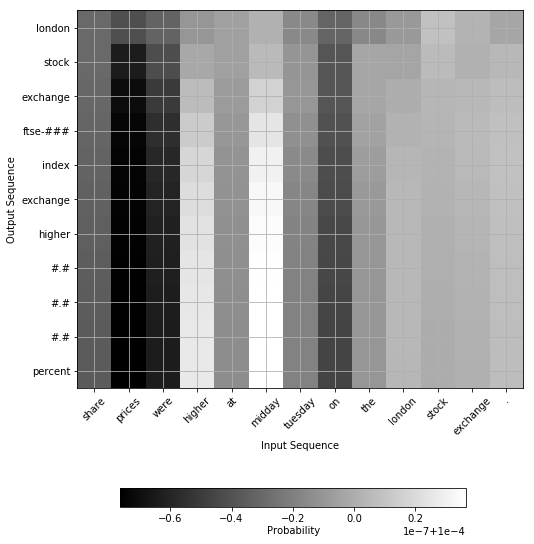

In [111]:
# TO-DO
text_summary='london stock exchange ftse-### index exchange higher #.# #.# #.# percent'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)



## (2) 

Article (I): 
 belarus won the men 's world cup #x# .# km biathlon relay here on saturday .

Title (G): 
 belarus win men 's world cup biathlon
 

Predicted summary with out attention (A): 
 to to to to to to to the nations 

Predicted summary with attention (A+):
 bobsled biathlon universiade universiade wins to in in asian cup 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


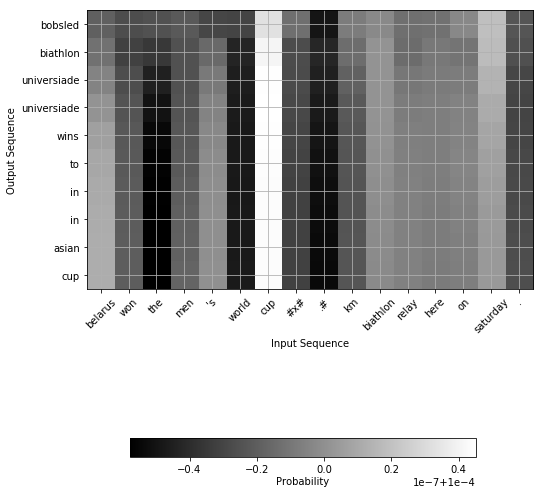

In [112]:
text_summary='bobsled biathlon universiade universiade wins to in in asian cup'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)


## (3) 

Article (I): 
 marlies schild of austria won her third straight world cup slalom thursday .

Title (G): 
 schild wins third straight world cup slalom
 

Predicted summary with out attention (A): 
 of for team 's in olympics 

Predicted summary with attention (A+):
 slalom cup italy results italy wins wins in world world cup 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


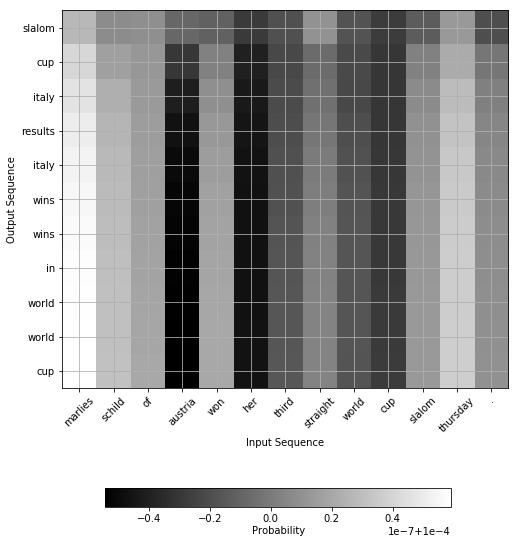

In [113]:

text_summary='slalom cup italy results italy wins wins in world world cup'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (4) 

Article (I): 
 thailand 's financial markets are closed on thursday for a public holiday .

Title (G): 
 thailand financial markets closed
 

Predicted summary with out attention (A): 
 stock closed for for for kills 

Predicted summary with attention (A+):
 shanghai closed holiday shanghai closed closed for in in holiday 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


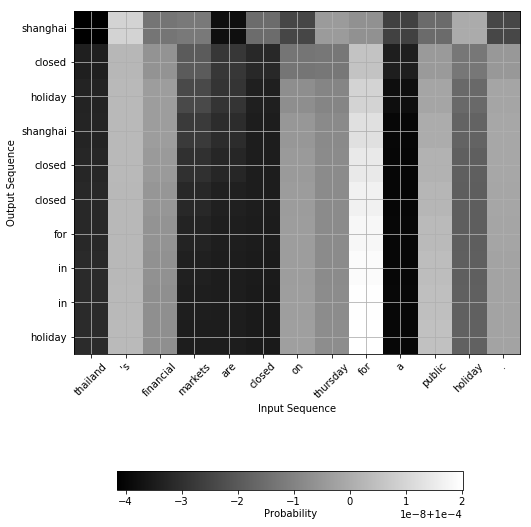

In [114]:

text_summary='shanghai closed holiday shanghai closed closed for in in holiday'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)


## (5) 

Article (I): 
 no other reliever in baseball was as dominant this season as brad lidge .

Title (G): 
 lidge provides advantage even when he doesn t
 

Predicted summary with out attention (A): 
 to in to to in in UNK 

Predicted summary with attention (A+):
 baseball anaheim UNK park tigers UNK UNK to for for the UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


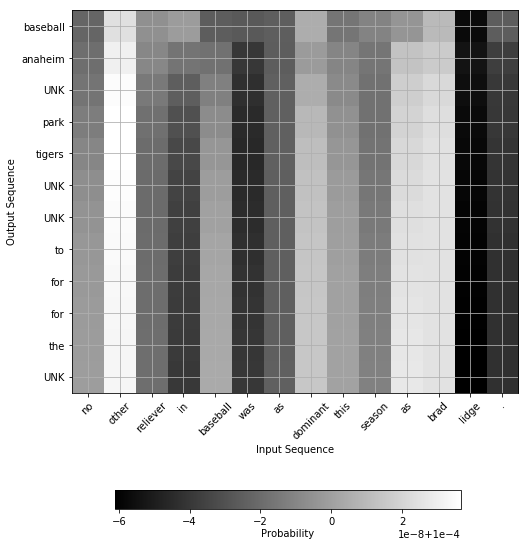

In [115]:
text_summary='baseball anaheim UNK park tigers UNK UNK to for for the UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)



## Bad 

## (1) 

Article (I): 
 would-be robbers take note : do n't use your debit card during a holdup .

Title (G): 
 robbery suspect uses debit card leading to arrest
 

Predicted summary with out attention (A): 
 UNK UNK the UNK 

Predicted summary with attention (A+):
 forget UNK UNK UNK UNK UNK UNK UNK in of UNK UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


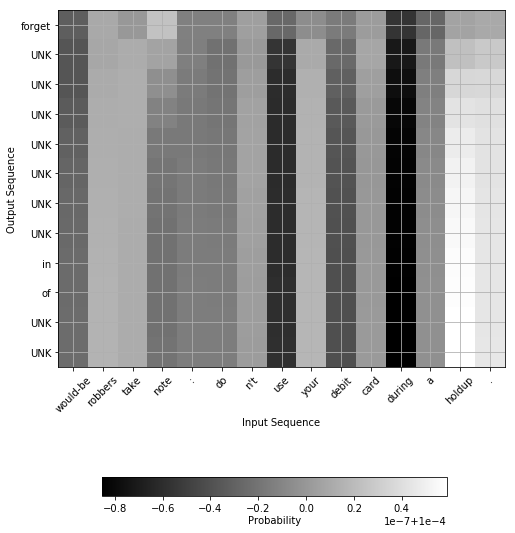

In [116]:
text_summary='forget UNK UNK UNK UNK UNK UNK UNK in of UNK UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (2) 

Article (I): 
 all at once , the media appear to have entered an era of public outrage .

Title (G): 
 <unk> alters public discourse on speech
 

Predicted summary with out attention (A): 
 to to to to to australia 

Predicted summary with attention (A+):
 district district UNK UNK UNK to UNK UNK UNK UNK in UNK UNK UNK UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


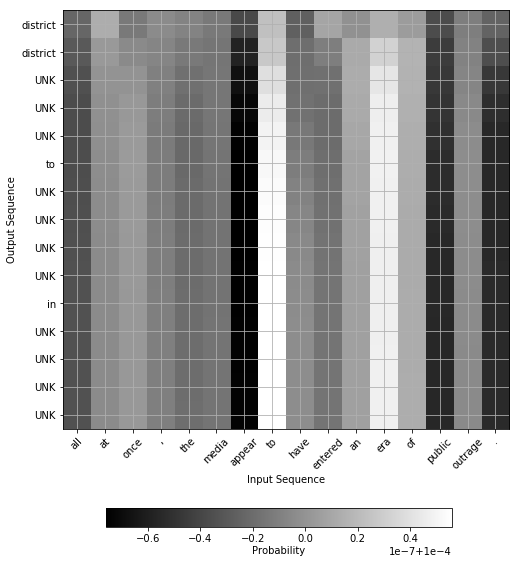

In [117]:
text_summary='district district UNK UNK UNK to UNK UNK UNK UNK in UNK UNK UNK UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (3) 

Article (I): 
 african americans have the highest rate of prostate cancer in the world .

Title (G): 
 cancer more common virulent among blacks
 

Predicted summary with out attention (A): 
 the a a the UNK 

Predicted summary with attention (A+):
 cancer cancer cancer cancer cancer cancer cancer of cancer in cancer cancer 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


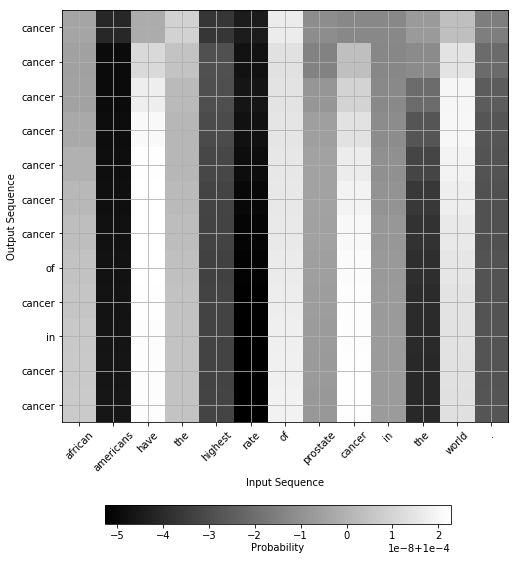

In [118]:
text_summary='cancer cancer cancer cancer cancer cancer cancer of cancer in cancer cancer'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (4) 

Article (I): 
 bollywood 's hottest husband and wife are sticking to a killer schedule .

Title (G): 
 bollywood s most famous newlyweds visit temple in southern india
 

Predicted summary with out attention (A): 
 UNK to for of UNK 

Predicted summary with attention (A+):
 wife wife UNK UNK UNK UNK UNK UNK in to in UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


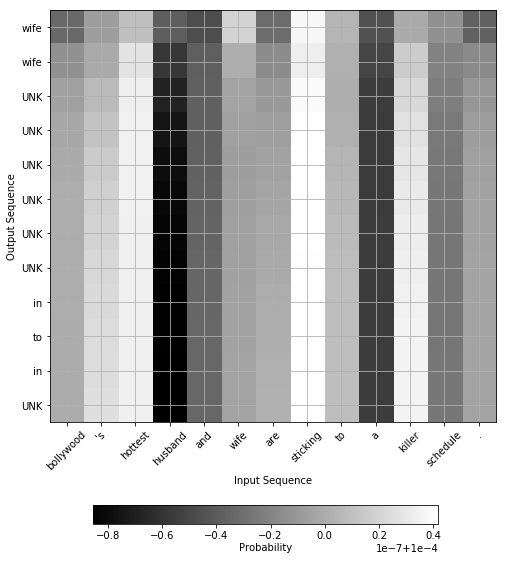

In [119]:
text_summary='wife wife UNK UNK UNK UNK UNK UNK in to in UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)


## (5) 

Article (I): 
 shares traded down ##.## points on the london stock exchange on tuesday .

Title (G): 
 ftse-### stock index down ##.## points at #,###.##
 

Predicted summary with out attention (A): 
 stock stock zealand up 

Predicted summary with attention (A+):
 london exchange exchange exchange exchange exchange exchange exchange exchange exchange in points 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


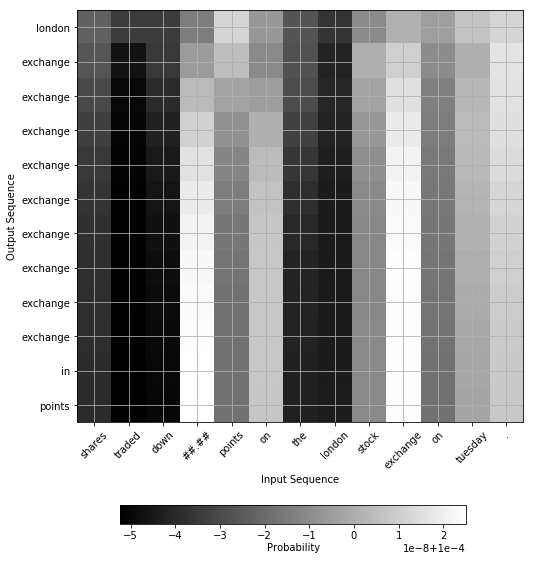

In [120]:
text_summary='london exchange exchange exchange exchange exchange exchange exchange exchange exchange in points'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## Random

## (1) 

Article (I): 
 democratic senate nominee ned lamont and sen. joseph lieberman , d-conn .

Title (G): 
 debate shows lamont 's problems against lieberman
 

Predicted summary with out attention (A): 
 of of of of of oil become 

Predicted summary with attention (A+):
 immigration support says voters UNK to on on on UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


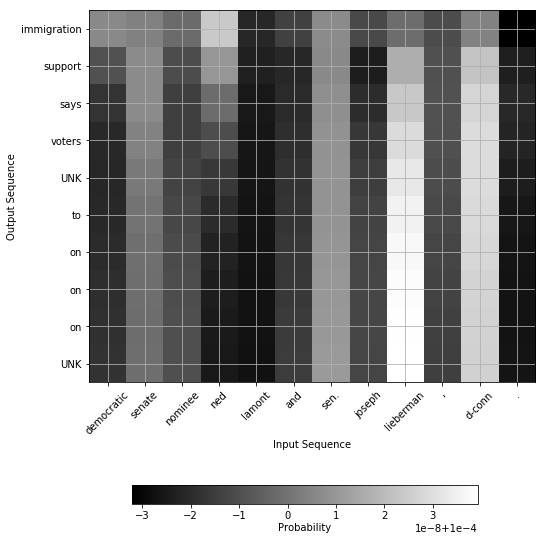

In [121]:
text_summary='immigration support says voters UNK to on on on UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (2) 

Article (I): 
 argentina could n't pull off the same type of shocker it did a year ago .

Title (G): 
 united states beats argentina ##-## in olympic qualifying
 

Predicted summary with out attention (A): 
 of of of of of to to of UNK 

Predicted summary with attention (A+):
 season UNK ## ## UNK UNK in in in in UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


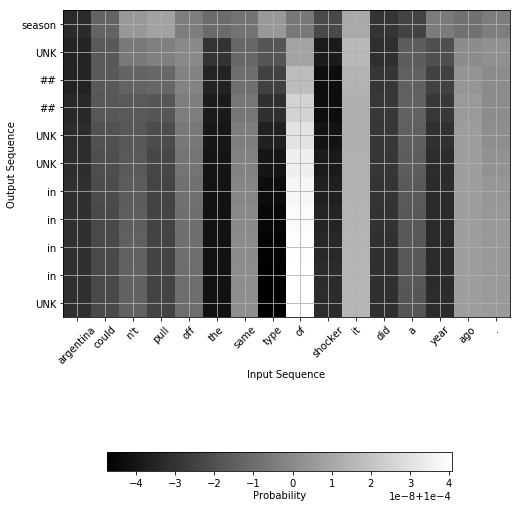

In [122]:

text_summary='season UNK ## ## UNK UNK in in in in UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (3) 

Article (I): 
 italian state railways workers called a seven-hour strike for wednesday .

Title (G): 
 unions call seven-hour strike against italian state railways
 

Predicted summary with out attention (A): 
 UNK to to for for wave 

Predicted summary with attention (A+):
 workers workers workers UNK to to in UNK in in UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


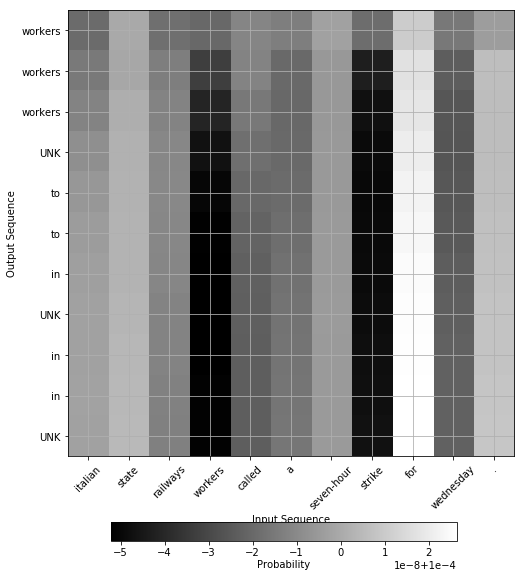

In [123]:
text_summary='workers workers workers UNK to to in UNK in in UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (4) 

Article (I): 
 england is n't exactly rushing to find sven-goran eriksson 's successor .

Title (G): 
 fa meets again to discuss who replaces eriksson
 

Predicted summary with out attention (A): 
 to to to to for for UNK 

Predicted summary with attention (A+):
 drew drew says says UNK UNK to to to to to with with UNK 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


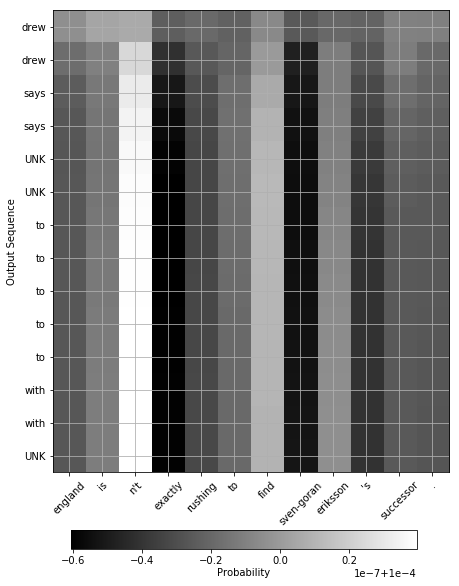

In [124]:
text_summary='drew drew says says UNK UNK to to to to to with with UNK'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

## (5) 

Article (I): 
 the five amateurs at this year 's masters played like , well , amateurs .

Title (G): 
 <unk> play like ... amateurs
 

Predicted summary with out attention (A): 
 's to to to to to to the UNK 

Predicted summary with attention (A+):
 masters masters classic ## UNK UNK to in in in the the year 



/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


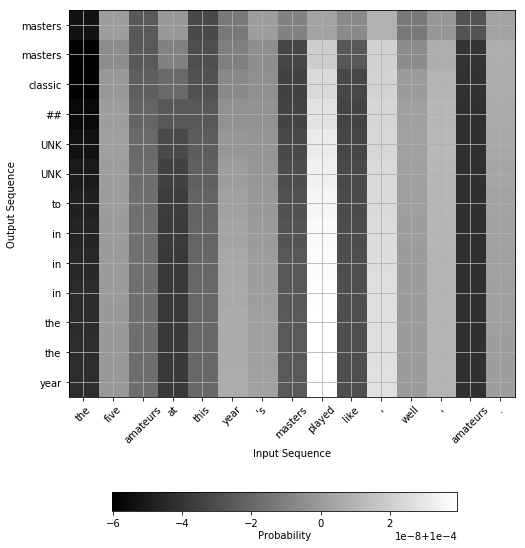

In [125]:
text_summary='masters masters classic ## UNK UNK to in in in the the year'
index=sequences_a.index(text_summary)
text = test_article[index]
title = test_summary[index]
print('Article (I): \n',text)
print('Title (G): \n',title,'\n')
print('Predicted summary with out attention (A): \n',sequences[index],'\n')
print('Predicted summary with attention (A+):\n',text_summary,'\n')
test_data_vector_article=X_test[index:index+1,:]
idx2word_title=y_ix2word
viz.attention_map(text,test_data_vector_article,idx2word_title)

### Discription of Output

The lighter the color, the higher the probability. We can see for some plots, they are strips, which means the probability is consentritued on some words than others. 

## Analysis of Errors and Comparisons

From above result, we can see that the model with attention generatlly is able to output more sophisticated results, which means it is able to generate better probability distribution among the words. 


However, the attention model usually show many repeted words like 'to' and 'UNK'. The reason for that should be we decreased the vocabulary size, which caused a lot of words categorized as UNK" since they are not in training dataset.

We further discovered that the golden rules are sometimes not good in terms of summarize the article sentense. Indeed, it sometimes is talking about different things which harms our model's performance. It maybe the reason why when I check the result, even it looks good sematically, it is not a good summary of the original text. 

## Proposal for Addressing Error

First, there are many 'UNK's due to the vocab_size we specified. IF we have more time, we can increase the vocab_size so that we can have more words in our vocabulary.

Besides, when we process the data, we did not use any filter. It may result that many "non-word" charactors like "##" to be recorded in the vocabulary set. We may develop better function to process our data.

Third, since the article and summary(title) sometimes do not match. We may change our dataset or use human annotators to create more accurate and high quality dataset.

# Unidirectional LSTM Encoder Decoder With Attention and Beam Search (Extra Credit)

The models that you implemented till now had greedy decoder. Now implement a Decoder with Beam Search and show improved results